# Adversarial Examples Using FGSM

This notebook demonstrates an adversarial example using Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) purposed by Goodfellow, et al. This article is also one of the first methods to fool a neural network.

## Adversarial Image Examples

Adversarial examples are processed inputs created to confuse the neural network. They are undistinguished to the human eyes but causing the neural network to fail to identify them. There are several attack methods, here the FGSM is one of the white box attacks, in which the hackers can access the model directly, and the goal is to make the neural network misunderstanding the images. The concept of the FGSM is the below image and is taken from the aforementioned paper.


![](https://www.tensorflow.org/tutorials/generative/images/adversarial_example.png)

Starting with the panda image, add some perturbations to it and make the network identify it as `gibbon`.

In [1]:
import logging
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s-%(levelname)s:%(message)s")
logging.info("Tensorflow Version: {}".format(tf.__version__))
logging.info("GPU is{} available.".format("" if tf.config.experimental.list_physical_devices("GPU") else " not"))

2020-12-30 07:45:33,843-INFO:Tensorflow Version: 2.4.0
2020-12-30 07:45:33,890-INFO:GPU is available.


## Fast Gradient Sign Method

The fast gradient sign method (FGSM) works by using the gradients of the neural network to create an adversarial image. Given an image, the FGSM uses the gradients of the loss with respect to it to create a new image that maximizes the loss. The new image is called the adversarial one. The basic idea can be summarised as below.

$$adv_x = x + \epsilon * sign(\nabla_xJ(\theta,x,y))$$

where
* $adv_x$ : Adversarial Image
* $x$ : the origin image
* $\epsilon$ : the perturbation factor
* $\theta$ : the model parameters
* $J$ : the loss

An interesting property here is the fact that gradients are taken with respect to the image. A method to accomplish this is to find how much each pixel in the image contributes to the loss value. This works by using the chain rule. In addition, since the model is no longer being trained, the only goal is to foolish the model.

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights="imagenet")
pretrained_model.trainable = False

# imagenet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def getImagenetLabel(probs):
  return decode_predictions(probs, top=1)[0][0]

In [4]:
img_path = tf.keras.utils.get_file('labrador.jpg', 
                                   'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
img_raw = tf.io.read_file(img_path)
img = tf.image.decode_image(img_raw)

img = preprocess(img)
img_probs = pretrained_model(img)
img_probs.shape

TensorShape([1, 1000])

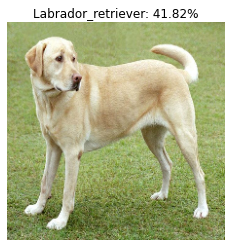

In [5]:
img_info, img_class, img_conf = getImagenetLabel(img_probs.numpy())

plt.figure()
plt.imshow(img[0] * 0.5 + 0.5)   # [-1, 1] to [0, 1]
plt.title('{}: {:.2f}%'.format(img_class, img_conf*100.0))
plt.axis("off")
plt.show()

In [6]:
lossObject = tf.keras.losses.CategoricalCrossentropy()

def createAdversarialPattern(image, label):
  with tf.GradientTape() as tape:
    tape.watch(image)
    pred = pretrained_model(image)
    losses = lossObject(label, pred)
  
  # the gradients are calculated with respect to the original image
  # to get the contribution of each pixel to the loss
  gradients = tape.gradient(losses, image)
  signs = tf.sign(gradients)
  return signs

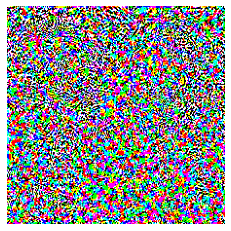

In [7]:
labrador_index = 208
labrador_label_index = tf.one_hot(labrador_index, img_probs.shape[-1])
labrador_label_index = tf.reshape(labrador_label_index, shape=(1, -1))

advPattern = createAdversarialPattern(img, labrador_label_index)
plt.imshow(advPattern[0] * 0.5 + 0.5)
plt.axis("off")
plt.show()

In [8]:
def displayImage(image, title):
  image_probs = pretrained_model.predict(image)
  _, image_class, image_conf = getImagenetLabel(image_probs)

  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)
  plt.title("{}\n{}:{:.2f}%".format(title, image_class, image_conf*100.0))
  plt.axis("off")
  plt.show()

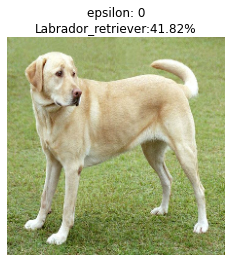

2020-12-30 07:45:38,658-WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


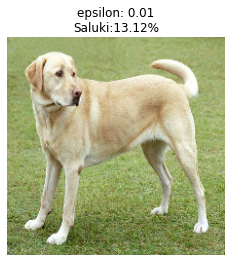

2020-12-30 07:45:38,869-WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


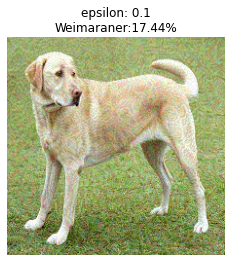

2020-12-30 07:45:39,085-WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


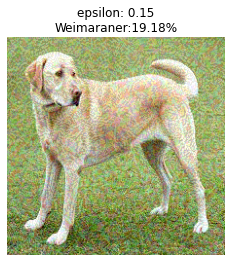

In [9]:
epsilons = [0, 0.01, 0.1, 0.15]
titles = ["epsilon: {}".format(eps) for eps in epsilons]

for eIdx in range(len(epsilons)):
  epsilon = epsilons[eIdx]
  advPattern = createAdversarialPattern(img, labrador_label_index)
  advImgs = img + epsilon * advPattern

  displayImage(advImgs, titles[eIdx])